### Code for running experiment
### Callin Switzer
### 21 Feb 2019

In [3]:
import nectarUtils
from nectarUtils import *
import nectarUtils as nu

import importlib


In [5]:
%matplotlib inline
print(sys.version)
print(sys.executable)

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarLearning\python.exe


In [6]:
# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

In [7]:
# list serial ports
nu.serial_ports()

['COM8']

In [8]:
# connect to com8
PORT1 = "COM8"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

Is nectar at the end of the tube, and the tube inserted correctly? [y/n]  y


{'base': 321, 'mid': 383}


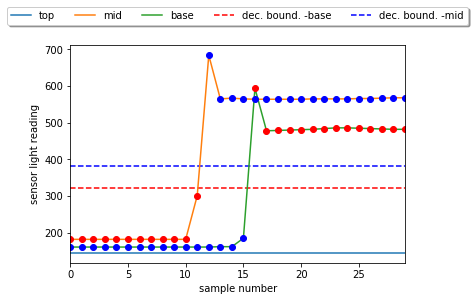

In [501]:
# reload package if changed
_ = importlib.reload(nectarUtils)

calb = nu.calibrate(ser1)

In [497]:
calb

{'base': 325, 'mid': 408}

In [496]:
ser1.write("".encode("utf-8"))

3

In [206]:
calb.head()

,a,b,c,d,e,f,timestamp
0,182,141,158,0,0,2019-03-07 14:35:17.683530,2019-03-07 14:35:17.683530
1,182,141,158,0,0,2019-03-07 14:35:17.773083,2019-03-07 14:35:17.773083
2,182,141,158,0,0,2019-03-07 14:35:17.873252,2019-03-07 14:35:17.873252
3,182,141,158,0,0,2019-03-07 14:35:17.973105,2019-03-07 14:35:17.973105
4,182,141,158,0,0,2019-03-07 14:35:18.073459,2019-03-07 14:35:18.073459


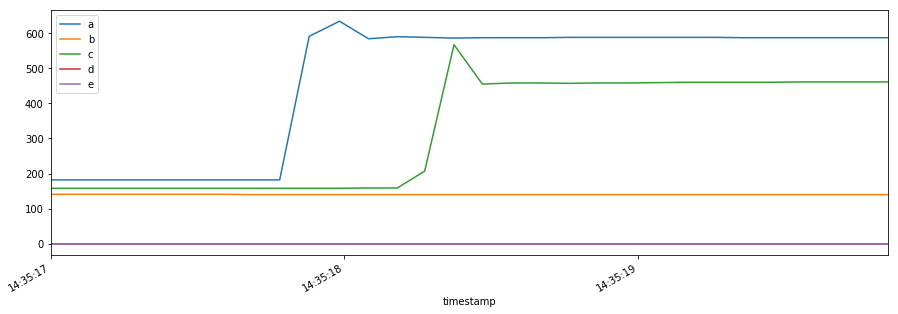

In [228]:
calb.plot(y=['a', 'b', 'c', 'd', 'e'], x = "timestamp", style='-', figsize=np.array([15, 5]))

{'base': 302, 'mid': 405}


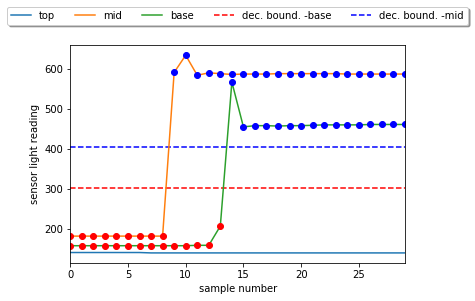

In [304]:
onsets = np.zeros(calb.shape[1]-2, dtype = 'int')
calb.columns = ['a', 'b', 'c', 'd', 'e', "time", "timestamp"]

for jj in range(calb.shape[1] - 2):

    dat = calb.iloc[:, jj].rolling(window=3, min_periods = 1, center = True).var()
    peaks, hts = find_peaks(dat, height=100)
    #print(calb.columns[jj])
    if(peaks.shape[0] > 0):
        onsets[jj] = int(peaks[np.argmax(hts['peak_heights'])])
        #dat.plot()
        #plt.scatter(x = peaks[np.argmax(hts['peak_heights'])], y = hts["peak_heights"][np.argmax(hts['peak_heights'])])
#         calb.plot(y=['a', 'b', 'c', 'd', 'e'], style='-')
#         plt.vlines(x = peaks[np.argmax(hts['peak_heights'])], ymin = 0, ymax = 700)
#         plt.show()
    
medVals = [np.median(calb.iloc[:,jj]) for jj in range(5)]

columns = np.zeros(5, dtype = 'object')
columns[onsets.argsort()[3]], columns[onsets.argsort()[4]] = "mid", "base"
columns[(columns != "mid") & (columns !="base") & (np.array(medVals) > 2)] = "top"
columns[columns == 0] = "limit"

columns = np.hstack([columns, ["time_S", "time"]])

calb.columns = columns
calb.head()
calb.plot(y=['top', 'mid', 'base'], style='-')

kmc = KMeans(n_clusters = 2)
ctr2 = 0
colors = ["red", 'blue']
decBounds = {"base": "", "mid": ""}
for location in ["base", "mid"]:
    classes = kmc.fit_predict(np.array(calb[location]).reshape(-1, 1))
    decBound = np.abs(np.median(np.array(calb[location])[classes == 1]) - 
                      np.median(np.array(calb[location])[classes == 0])).astype(int)
    decBounds[location] = decBound
    plt.plot(calb[location][classes == 0], 'bo', label = "")
    plt.plot(calb[location][classes == 1], 'ro', label = "")
    plt.hlines(y = decBound, xmin = 0, xmax = calb.shape[0], 
               linestyle = "--", color = colors[ctr2], label = "dec. bound. -" + str(location))
    ctr2 += 1
plt.ylabel("sensor light reading")
plt.xlabel("sample number")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=5)
print(decBounds)

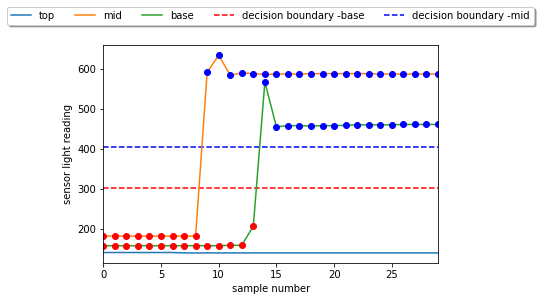

In [298]:
onsets = np.zeros(calb.shape[1]-2, dtype = 'int')
calb.columns = ['a', 'b', 'c', 'd', 'e', "time", "timestamp"]

for jj in range(calb.shape[1] - 2):

    dat = calb.iloc[:, jj].rolling(window=3, min_periods = 1, center = True).var()
    peaks, hts = find_peaks(dat, height=100)
    #print(calb.columns[jj])
    if(peaks.shape[0] > 0):
        onsets[jj] = int(peaks[np.argmax(hts['peak_heights'])])
        #dat.plot()
        #plt.scatter(x = peaks[np.argmax(hts['peak_heights'])], y = hts["peak_heights"][np.argmax(hts['peak_heights'])])
#         calb.plot(y=['a', 'b', 'c', 'd', 'e'], style='-')
#         plt.vlines(x = peaks[np.argmax(hts['peak_heights'])], ymin = 0, ymax = 700)
#         plt.show()
    
medVals = [np.median(calb.iloc[:,jj]) for jj in range(5)]

columns = np.zeros(5, dtype = 'object')
columns[onsets.argsort()[3]], columns[onsets.argsort()[4]] = "mid", "base"
columns[(columns != "mid") & (columns !="base") & (np.array(medVals) > 2)] = "top"
columns[columns == 0] = "limit"

columns = np.hstack([columns, ["time_S", "time"]])

calb.columns = columns
calb.head()
calb.plot(y=['top', 'mid', 'base'], style='-')


from sklearn.cluster import DBSCAN
kmc = KMeans(n_clusters = 2)

#kmc = DBSCAN(eps = 10)
ctr2 = 0
colors = ["red", 'blue']
for location in ["base", "mid"]:
    classes = kmc.fit_predict(np.array(calb[location]).reshape(-1, 1))
    decBound = np.abs(np.median(np.array(calb[location])[classes == 1]) - 
                      np.median(np.array(calb[location])[classes == 0]))
    plt.plot(calb[location][classes == 0], 'bo', label = "")
    plt.plot(calb[location][classes == 1], 'ro', label = "")
    plt.hlines(y = decBound, xmin = 0, xmax = calb.shape[0], 
               linestyle = "--", color = colors[ctr2], label = "decision boundary -" + str(location))
    ctr2 += 1
plt.ylabel("sensor light reading")
plt.xlabel("sample number")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=True, shadow=True, ncol=5)

ValueError: invalid literal for int() with base 10: 'cldh'

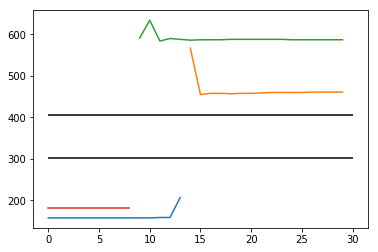

In [264]:
# 2 find clusters for sensors
# 1 label sensors automatically (first one to move is middle, second is base), no movement is top
kmc = KMeans(n_clusters = 2)
for location in ["base", "mid"]:
    classes = kmc.fit_predict(np.array(calb[location]).reshape(-1, 1))
    decBound = np.abs(np.median(np.array(calb[location])[classes == 1]) - 
                      np.median(np.array(calb[location])[classes == 0]))
    plt.plot(calb[location][classes == 0])
    plt.plot(calb[location][classes == 1])
    plt.hlines(y = decBound, xmin = 0, xmax = calb.shape[0])

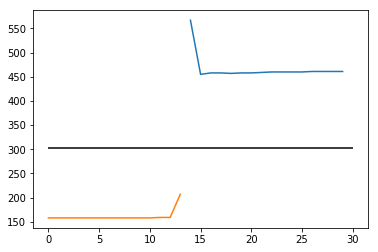

In [239]:
plt.plot(calb["base"][classes == 0])
plt.plot(calb["base"][classes == 1])
plt.hlines(y = decBound, xmin = 0, xmax = calb.shape[0])

In [ ]:
# reload package if changed
_ = importlib.reload(nectarUtils)


# read and save data
stt = time.time()

newDat = nu.readAndSave(ser1, maxTime=600*2, saveData=True, dataDir = dataDir, timeout = 600*2, minRewardThreshold = 170)

print(time.time() - stt)
newDat.head()

newDat['timestamp'] = pd.to_datetime(newDat['timestamp'])
newDat['delta'] = (newDat['timestamp']-newDat['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))

newDat.plot(y=['top_sensor', 'mid_sensor', 'base_sensor'], x = "timestamp", style='-', figsize=np.array([15, 5]))

plt.scatter(y=newDat['top_sensor'], x = newDat["timestamp"])
plt.vlines(newDat[newDat.notes == "reward Triggered"]["timestamp"], ymin = 0, ymax = 1000, label = "reward")

#newDat.plot(y=['delta'], x = "timestamp", style='-')

In [ ]:
# reload package if changed
_ = importlib.reload(nectarUtils)


# read and save data
stt = time.time()

newDat = nu.readOnly(ser1, maxTime=5, saveData=True, dataDir = dataDir, timeout = 600*2)

print(time.time() - stt)
newDat.head()

newDat['timestamp'] = pd.to_datetime(newDat['timestamp'])
newDat['delta'] = (newDat['timestamp']-newDat['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))

newDat.plot(y=['top_sensor', 'mid_sensor', 'base_sensor'], x = "timestamp", style='-', figsize=np.array([15, 5]))

plt.scatter(y=newDat['top_sensor'], x = newDat["timestamp"])
plt.vlines(newDat[newDat.notes == "reward Triggered"]["timestamp"], ymin = 0, ymax = 1000, label = "reward")

#newDat.plot(y=['delta'], x = "timestamp", style='-')

In [ ]:
newDat.plot(y=['top_sensor', 'mid_sensor', 'base_sensor'], x = "timestamp", style='-', figsize=np.array([15, 5]))

plt.scatter(y=newDat['top_sensor'], x = newDat["timestamp"])
plt.vlines(newDat[newDat.notes == "reward Triggered"]["timestamp"], ymin = 0, ymax = 1000, label = "reward")
plt.hlines(y = 150, xmin = np.min(newDat["timestamp"]), xmax = np.max(newDat["timestamp"]), label = "thresh")

In [ ]:
int.from_bytes(b'b', byteorder='big')

In [ ]:
numSteps = 4
[ser1.write("b".encode("utf-8")) for ii in range(numSteps)]


# for com7
df1[["base_sensor", "mid_sensor", 
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

df1.head()

In [ ]:
# for com8, switch base and mid refref, double check
tt = readData(ser1, readlen=10, wait_time=0.0, save=True, returnVals = True)
df1 = pd.DataFrame(tt, columns=["base_sensor", "mid_sensor", "top_sensor", "limit_1", "limit_2", "timestamp"])

df1[["mid_sensor", "base_sensor",
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

print(df1.shape)
df1.head()

In [ ]:
df1.tail()

In [ ]:
#np.array(df1.iloc[:,0].astype(int))

In [ ]:
ax1 = df1.iloc[:, 0:3].plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')  

In [ ]:
plt.plot(df1[["base_sensor", "mid_sensor", 
     "top_sensor"]])
plt.show()

In [ ]:
plt.plot(np.array(df1.iloc[:,1].astype(int)))

In [ ]:
plt.plot(np.array(df1.iloc[:,2].astype(int)))

In [ ]:
(tt[0, 5])

In [ ]:
# for com7
# top sensor
tt[:, 2]

# mid sensor
tt[:, 1]

# base sensor
tt[:, 0]

In [ ]:
plt.plot(tt[:,2])

In [ ]:
plt.plot(tt)

In [ ]:
#ser1.close()

In [ ]:
def moveToTop(serial_con, cutoff = 650):
    # refref: may want to go 1 or two more moves forward after cutoff is passed --- 
    ## the cutoff is the meniscus
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    print(topVal)
    while (topVal > cutoff) and not topLim:
        #move forward
        ser1.write("f".encode("utf-8"))
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:,[1,3,4]]
        # rror if limit switch is hit
        if topLim:
            raise RuntimeError('Hit upper limit switch')
        
        
        
        

In [ ]:
# refref: problem -- liquid stays stuck on the sides -- may need to move back slower

def moveBack(serial_con, cutoff = 650):
    
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    
    
    while (topVal < cutoff) and not bottomLim:
        #move backward
        for jj in range(7):
            ser1.write("b".encode("utf-8"))
            time.sleep(0.3)
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
        # rror if limit switch is hit
        if bottomLim:
            raise RuntimeError('Hit lower limit switch')

In [ ]:
readData(ser1, 1, 0)

In [ ]:
moveToTop(ser1)
readData(ser1, 1, 0)

In [ ]:
moveBack(ser1)
readData(ser1, 1, 0)

In [ ]:
ser1.write("f".encode("utf-8"))

In [ ]:
[[vals, bottomLim, topLim]] = readData(ser1, 1, 0)[:, 2:]

In [ ]:
readData(ser1, 1, 0)[:, 2:]

In [ ]:
toplim = 1

In [ ]:
not toplim

for ii in range(20): 
    written = ser1.write("f".encode("utf-8"))


ser1.write("f".encode("utf-8"))

for ii in range(100): 
    written = ser1.write("b".encode("utf-8"))

"c".encode("utf-8")
int.from_bytes(b'c', byteorder='big') # this is what the arduino will see

int.from_bytes(b'c', byteorder='big')

ser1.write("c".encode("utf-8"))